In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#Was run on google colab alongside all of my other tests 

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Deep Reinforcement Learning/Coursework' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', '__init__.py', 'DQN.py', 'replay_buffer.py', 'policy.py', 'utility_fun.py', 'DQN_HER_lr00001_BS256_TU4.ipynb', 'DQN_HER_lr000001_BS256_TU20.ipynb', 'DQN_HER_lr00001_BS128_TU20.ipynb', 'DQN_HER_lr00001_BS256_TU20.ipynb', 'DQN_HER_lr00001_BS128_TU4.ipynb', 'sparse_lander.py', 'DuellingDQN.py']


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Deep Reinforcement Learning/Coursework')

In [4]:
###LUNAR LANDER WON'T RUN WITHOUT THESE PACKAGES###
!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [5]:
import gym

In [6]:
env = gym.make("LunarLander-v2")

In [7]:
import copy

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as Tb

from sparse_lander import Sparse_Lander

from utility_fun import Utils, ReplayMemory
from DuellingDQN import DuellingDQN
from DQN import DQN
from policy import E_Greedy_Policy

In [8]:
env = gym.make("LunarLander-v2")
lun = Sparse_Lander(env)

In [9]:
OBS_SIZE = 10
HIDDEN_SIZE = 64

BATCH_SIZE = 128
GAMMA = 0.999

n_actions = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Q_network = DuellingDQN(OBS_SIZE, HIDDEN_SIZE, n_actions).to(device)
Q_target = DuellingDQN(OBS_SIZE, HIDDEN_SIZE, n_actions).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 20

optimizer = optim.Adam(Q_network.parameters(), lr=0.00001)
memory = ReplayMemory(100000)

In [10]:
policy = E_Greedy_Policy(0.99, decay=0.9995, min_epsilon=0.001)

In [11]:
### Borrowed and adapted from Lab 6/ Pytorch DQN tutorial ###
#NUM_EPISODES = 3000
NUM_EPISODES = 3000
rewards_history = []
success_history = []
success_rate = []
# Warmup phase!
memory_filled = False
her_replay_tracker = []
while not memory_filled:
    
    state = lun.reset(0.25)
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action
        state_tensor = Utils.convert_state(state, lun.goal, device)
        
        action = policy(state_tensor, n_actions, device, Q_network)
      
        next_state, reward, done, _ = lun.step(action.item())
        
        total_reward += float(reward)
        
        
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward), her_replay_tracker, lun.goal, device)


    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')

for i_episode in range(NUM_EPISODES):
      her_replay_tracker = [] #initialise replay tracker
      
      state = lun.reset(0.25) #reset env with threshold
      done = False
      
      total_reward = 0
      count = 0
      success = 0 #count number of succeesses
      while not done:

              # Get action and act in the world
              state_tensor = Utils.convert_state(state, lun.goal, device)
              #need to append env.goal to the state tensor
              action = policy(state_tensor, n_actions, device, Q_network) #use policy to get action

              next_state, reward, done, _ = lun.step(action.item()) #take action to get next state
     
       
              total_reward += float(reward)
              if reward == 1:
                success = 1 #if reward is 1 then success

              if done:
                  next_state = None

              # Store the transition in memory
              memory.push(state, action, next_state, float(reward), her_replay_tracker, lun.goal, device) #add state and next state with new goal to the replay buffer

              count += 1
              
              # Move to the next state if not terminal
              if next_state is not None:
                  state = next_state

              # optimize model
              started_training = True
              l = Utils.optimize_model(device, memory, BATCH_SIZE, Q_network, Q_target, GAMMA, optimizer)
      #lun.HER_new_goal(state) #to adapt for 'final' strategy!
      ### HER ###
      #inspired by: https://deeprobotics.wordpress.com/2018/03/07/bitflipper-herdqn/
      # https://medium.com/@jscriptcoder/yet-another-hindsight-experience-replay-refining-the-plan-3dcf8ede6f4a
      # https://www.youtube.com/watch?v=Dvd1jQe3pq0
      
      for t in range(count): #for all experiences in previous episode

          s, a, n_s, _ = (copy.deepcopy(her_replay_tracker[t])) #get state, action, next state for eaech time step
          
          if n_s is not None: 
            n_s_ = (n_s[:][0][:5]).cpu().numpy() #take next state without goal appended
          try:
            her_transitions = np.random.randint(t+1, count, 5) #sample 5 random goals from states ahead of current timestep for future strategy (here k = 5)

            for k in range(0,4): #k = 5 loop over all 5 randomly sampled goals in future
                s_future, a_future, n_s_future, _ = (copy.deepcopy(her_replay_tracker[her_transitions[k]])) #get state, action andd next state for the future goal
                s_future_ = (s_future[:][0][:5]).cpu().numpy() #get the state to create new goal

                lun.HER_new_goal(s_future_) #set state of random sample as goal

                r_ = lun.sparse_rewards(n_s_) #calculate rewards
                #print(r_)
              #  print(r_)
                if n_s is not None: 
                  memory.HER_push((s[:][0][:5]).cpu().numpy(), a, (n_s[:][0][:5]).cpu().numpy(), float(r_), lun.goal, device) #add to buffer!
                l = Utils.optimize_model(device, memory, BATCH_SIZE, Q_network, Q_target, GAMMA, optimizer) #optimize 
          except: 
            pass
      ### IF USING THE FINAL STRATEGY ###
      #for t in range(count): #from zero to the index of the new goal

       #   s, a, n_s, _ = (copy.deepcopy(her_replay_tracker[t]))

        #  if n_s is not None: 
         #   n_s_ = (n_s[:][0][:5]).cpu().numpy() 
         # try:
  
          #  r_ = lun.sparse_rewards(n_s_)
                #print(r_)
              #  print(r_)
           # if n_s is not None: 
            #  memory.HER_push((s[:][0][:5]).cpu().numpy(), a, (n_s[:][0][:5]).cpu().numpy(), float(r_), lun.goal, device)
            #l = Utils.optimize_model(device, memory, BATCH_SIZE, Q_network, Q_target, GAMMA, optimizer)
          #except: 
          #  pass
          ###############
      policy.update_epsilon()
      rewards_history.append( float(total_reward) )
      success_history.append(success)
      # Update the target network, copying all weights and biases in DQN
      if i_episode % TARGET_UPDATE == 0:
          Q_target.load_state_dict(Q_network.state_dict())
      
      if (i_episode) % 10 == 0:
          #print(r)
          print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', ' loss:', l.detach().cpu().numpy())   
          print( sum(rewards_history[-10:])/10)    
          print(sum(success_history[-10:])/10)
      if i_episode % 100 == 0:
          success_rate.append(sum(success_history[-100:])/100)
 
print('Complete')

Done with the warmup
Episode  0 :  reward : -78.0 eps:   loss: 0.0888554
-7.8
0.0
Episode  10 :  reward : -61.0 eps:   loss: 0.036045853
-90.8
0.1
Episode  20 :  reward : -84.0 eps:   loss: 0.15377419
-99.5
0.0
Episode  30 :  reward : -103.0 eps:   loss: 0.47336578
-99.6
0.0
Episode  40 :  reward : -62.0 eps:   loss: 1.7000335
-85.8
0.1
Episode  50 :  reward : -102.0 eps:   loss: 5.404086
-100.7
0.0
Episode  60 :  reward : -69.0 eps:   loss: 10.992051
-98.5
0.0
Episode  70 :  reward : -74.0 eps:   loss: 51.275177
-88.1
0.0
Episode  80 :  reward : -92.0 eps:   loss: 122.324455
-91.5
0.1
Episode  90 :  reward : -59.0 eps:   loss: 311.14014
-107.9
0.0
Episode  100 :  reward : -100.0 eps:   loss: 463.74106
-88.0
0.0
Episode  110 :  reward : -92.0 eps:   loss: 764.5251
-91.8
0.0
Episode  120 :  reward : -92.0 eps:   loss: 1021.7253
-93.9
0.0
Episode  130 :  reward : -73.0 eps:   loss: 1543.1858
-104.8
0.0
Episode  140 :  reward : -108.0 eps:   loss: 2063.9749
-84.7
0.0
Episode  150 :  rewar

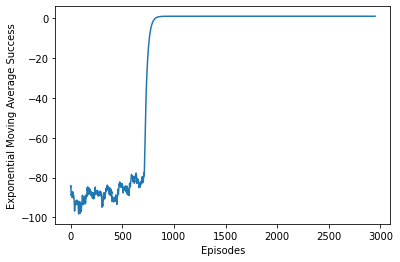

In [15]:

Utils.plot_experiments(rewards_history, ema_coefficient=0.96)

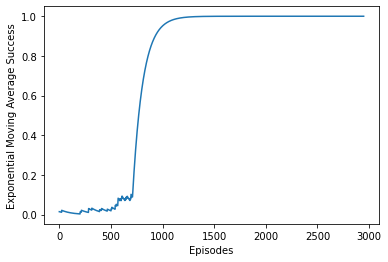

In [18]:
Utils.plot_experiments(success_history, ema_coefficient=0.99)

Text(0, 0.5, 'Success Rate')

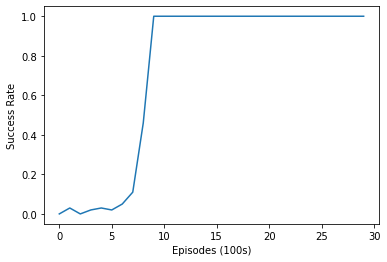

In [17]:
plt.plot(success_rate)
plt.xlabel("Episodes (100s)")
plt.ylabel("Success Rate")